# 2019-08-08 spyros without fetal & hybrid cells
# run 3 for manuscript

In [105]:
import pandas as pd
import numpy as np
import loompy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import matplotlib as mpl
import imp
import sys
import semiannotate 

sys.path.append('/home/bojk/Data/minimeta_pyfiles/')
import semiAnnotate_main as sam
import semiAnnotate_Sankey as sank
import semiAnnotate_dotplot as sdot
import get_timestamp as time

In [106]:
# load data
# darmanis brain atlas
BA_count_path = '../leidenalg/Datasets/Darmanis_Brain/All_cell_counts_brain.csv'
BA_counttable = pd.read_csv(BA_count_path,index_col=0)
BA_meta = pd.read_csv('../leidenalg/Datasets/Darmanis_Brain/All_cell_info_brain.csv',sep=';',index_col=0)

#darmanis glioblastoma dataset (to annotate based on brain atlas)
GBM_count_path = '../leidenalg/Datasets/Darmanis_Glioblastoma/GBM_data_and_metadata/GBM_raw_gene_counts.csv'
GBM_counttable = pd.read_csv(GBM_count_path,sep=' ',index_col=0)
GBM_meta = pd.read_csv('../leidenalg/Datasets/Darmanis_Glioblastoma/GBM_data_and_metadata/GBM_metadata.csv',sep=' ',index_col=0)
GBMtsne = pd.read_csv('../leidenalg/Datasets/Darmanis_Glioblastoma/GBM_data_and_metadata/GBM_TSNE.csv',sep=' ',index_col=0)
GBM_meta = GBM_meta.join(GBMtsne)
# add annotation from separate file
GBMmeta2= pd.read_csv('../leidenalg/Datasets/Darmanis_Glioblastoma/GBM_data_and_metadata/GEO_upload/spyros.darmanis_metadata_GBM.csv',index_col=0)
GBM_meta = GBM_meta.join(GBMmeta2['characteristics: cell type'])
GBM_meta.rename(index=str,columns={'characteristics: cell type':'Cell_type2'},inplace=True)

lut = {'Astocyte':'Astrocytes','Neuron':'Neurons','Oligodendrocyte':'Oligodendrocytes','Vascular':'Endothelial'
       ,'Immune cell':'Immune cell', 'Neoplastic':'Neoplastic','OPC':'OPC'}

GBM_meta['Cell_type'] = GBM_meta['Cell_type2'].map(lut)

In [3]:
idx_fetal = list(BA_meta[~BA_meta.Cell_type.str.contains('Fetal')].index)
BA_newmet = BA_meta[BA_meta.index.isin(idx_fetal)].copy()# no fetal cells 
idx_hyb = list(BA_newmet[~BA_newmet.Cell_type.str.contains('ybrid')].index)
BA_newmeta = BA_newmet[BA_newmet.index.isin(idx_hyb)].copy()# no hybrid cells 
BA_newcounts = BA_counttable[BA_newmeta.index].copy()

# feature select first run

# no self-edging, with atlas genes


In [95]:
imp.reload(sam)
import get_timestamp as time
date = time.datenum_complete()
savedir = '../leidenalg/Datasets/Darmanis_Brain/'
atlasgenes = 50
atlasweights = 20

keys = ['cell type column','number of features cell type','number of features new data'
        ,'weights_atlas_cells','timestamp','savedir']
values = ['Cell_type',atlasgenes,600,atlasweights,date,savedir]
kwds = dict(zip(keys,values))
matrix,weights, BA_meta,GBM_meta = sam.normmerge_twoCounttables(BA_newcounts,
                                                                             BA_newmeta, GBM_counttable, GBM_meta, **kwds)
matrix_feature_selected = sam.feature_select(matrix.dropna(how='all',axis=1),BA_meta,**kwds)

kwds['threshold_neigborhood'] = thresn = .8  
kwds['n_pcs'] = n_pcs = 20 
kwds['resolution_parameter'] = respar = .005 
kwds['self_edging'] = False
kwds['select_features']=False

tsnedf, class_numbers,vals,wdm = sam.semiAnnotate_to_pca_to_tsnedf(matrix_feature_selected,weights,BA_newmeta,GBM_meta,**kwds)

-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5']
-------------------------------------------
-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5', 'ERCC1', 'ERCC2', 'ERCC3', 'ERCC4', 'ERCC5', 'ERCC6', 'ERCC6L', 'ERCC8']
-------------------------------------------
-------------------------------------------
Cell types in atlas:
['Astrocytes' 'Endothelial' 'Microglia' 'Neurons' 'OPC' 'Oligodendrocytes']
-------------------------------------------
Cell types in new data:
['Astrocytes' 'Endothelial' 'Immune cell' 'Neoplastic' 'Neurons' 'OPC'
 'Oligodendrocytes']
-------------------------------------------
-------------------------------------------
Selected number of genes from atlas:
300
-------------------------------------------
Selected number of genes from new cells:
600
-------------------------------------------
Combined total of selected genes:
876
-------------------------------------------
--

In [96]:
tsnedf['new_membership'].value_counts()
len(class_numbers)

10

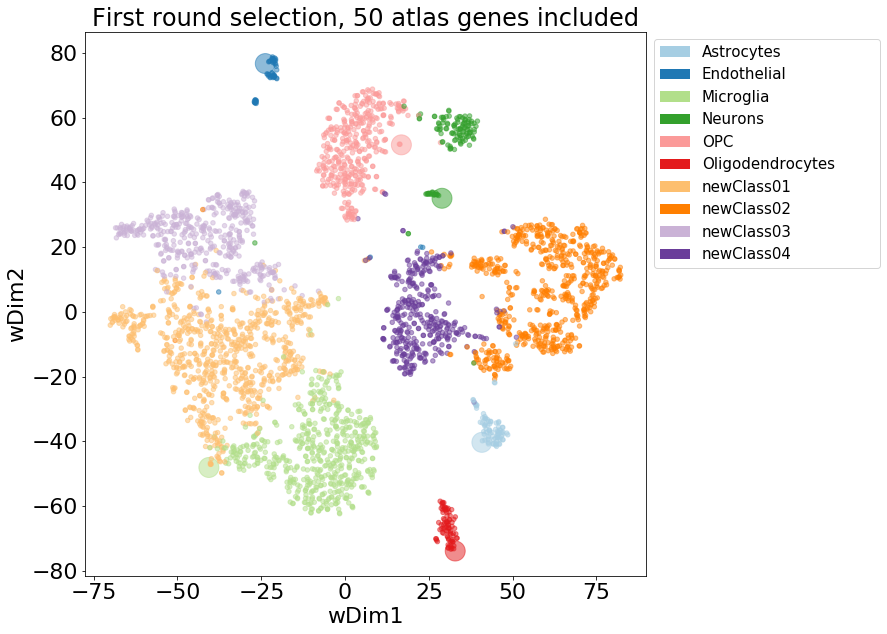

In [97]:
if len(class_numbers)>10:
    newlut = dict(zip(class_numbers,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(class_numbers)-10)))
else:
    newlut = dict(zip(class_numbers,sns.color_palette('Paired', 10)))
newcolor = tsnedf['class'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
tsnedf.plot.scatter('wDim1','wDim2',s=weights*20
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,vals,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_noselfEdges_equalweight_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_noselfEdges_equalweight_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.pdf')

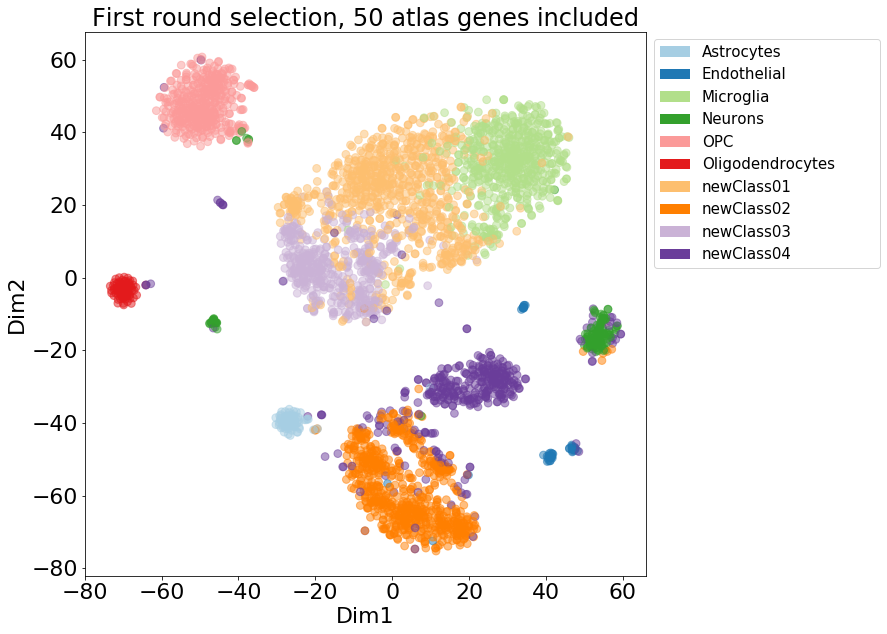

In [98]:
idx = tsnedf[6:].index
GBM_meta.loc[idx,'new_membership'] = tsnedf.iloc[6:]['new_membership']
# new results mapped onto old tSNE
newlut = dict(zip(vals,sns.color_palette('Paired', 10)))#+sns.color_palette('BrBG',len(vals)-10)))
newcolor = GBM_meta['new_membership'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
GBM_meta.plot.scatter('Dim1','Dim2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_noselfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_noselfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.pdf')

# subsample

In [84]:
matrix.head()
#instead of normmerge 2 counttables, we need to pick N random cells per class and feed this to the matrix. 
#also add an atlas_annotations array

,Astrocytes,Endothelial,Microglia,Neurons,OPC,Oligodendrocytes,1001000173.G8,1001000173.D4,1001000173.B4,1001000173.A2,...,1001000271.C2,1001000271.D1,1001000271.B1,1001000271.A3,1001000271.E1,1001000271.F1,1001000271.D4,1001000271.C1,1001000271.H7,1001000271.H2
1/2-SBSRNA4,6.608249,0.0,0.000000,7.590735,2.388539,1.179862,3.697828,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
A1BG,0.104002,0.0,2.619611,2.071216,0.000000,13.859040,0.000000,0.0,0.0,0.000000,...,17.137667,42.836642,0.0,0.0,0.0,0.0,256.968696,0.0,0.0,0.0
A1BG-AS1,0.000000,0.0,0.000000,0.914208,0.000000,0.592837,0.000000,0.0,0.0,1.417404,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
A1CF,0.019340,0.0,0.000000,0.277727,97.887545,0.033812,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
A2LD1,8.272187,0.0,0.000000,0.131847,0.000000,0.036357,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [102]:
imp.reload(sam)
kwds['number_of_cells_per_type'] = 20
matrix_sub,annot,annotdict, BA_meta,GBM_meta = sam.normmerge_twoCounttables_subsample(BA_newcounts,
                                                                             BA_newmeta, GBM_counttable, GBM_meta, **kwds)
matrix_feature_selected_sub = sam.feature_select_sub(matrix.dropna(how='all',axis=1),annot,BA_meta,**kwds)
#matrix??
tsnedfSU, class_numbersSU,valsSU = sam.semiAnnotate_subsample(matrix_feature_selected_sub,annot,BA_newmeta,GBM_meta,**kwds)

-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5']
-------------------------------------------
-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5', 'ERCC1', 'ERCC2', 'ERCC3', 'ERCC4', 'ERCC5', 'ERCC6', 'ERCC6L', 'ERCC8']
-------------------------------------------
-------------------------------------------
Cell types in atlas:
['Astrocytes' 'Endothelial' 'Microglia' 'Neurons' 'OPC' 'Oligodendrocytes']
-------------------------------------------
Cell types in new data:
['Astrocytes' 'Endothelial' 'Immune cell' 'Neoplastic' 'Neurons' 'OPC'
 'Oligodendrocytes']
-------------------------------------------
120
-------------------------------------------
Selected number of genes from atlas:
300
-------------------------------------------
Selected number of genes from new cells:
600
-------------------------------------------
Combined total of selected genes:
882
------------------------------------------

In [57]:
len(annot)

120

In [58]:
L,N = matrix_feature_selected_sub.shape
aau = np.unique(annot)
aa= annot
n_fixed = len(aa)

tmp = set(aau)
initial_membership = list(aa)
i = 0
for j in range(N - n_fixed):
    while i in tmp:
        i += 1
    initial_membership.append(i)
    tmp.add(i)
    i += 1
del tmp

initial_membership = list(aa) + list(np.arange(N - n_fixed) + len(aau))

In [69]:
import leidenalg
import igraph as ig
g = ig.Graph(N)
partition = leidenalg.CPMVertexPartition(g, initial_membership=initial_membership)

In [55]:
len(initial_membership)==N

True

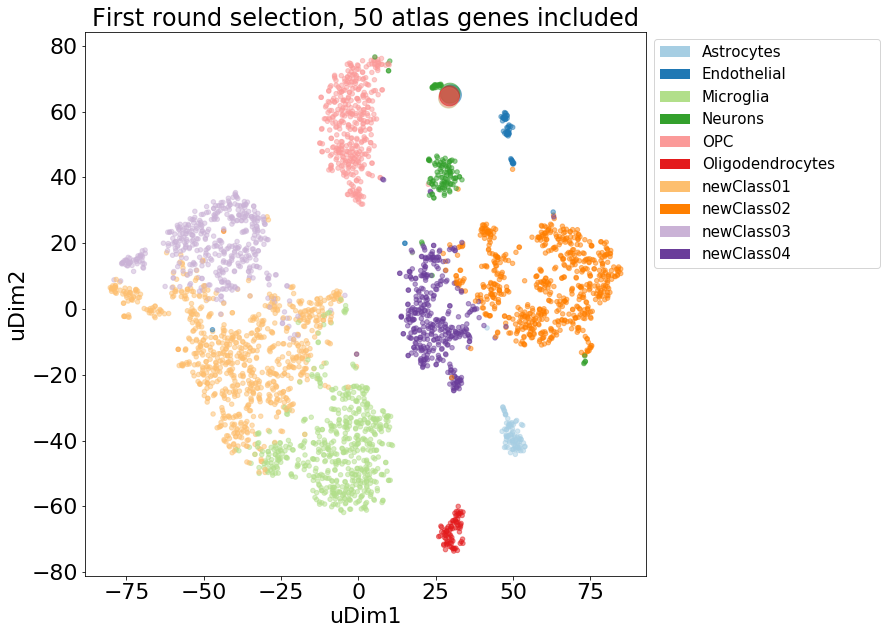

In [104]:
newlut = dict(zip(class_numbers,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(class_numbers)-10)))
newcolor = tsnedf['class'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
tsnedfSU.plot.scatter('uDim1','uDim2',s=weights*20
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,vals,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_subsampling_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_subsampling_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.pdf')

In [ ]:
idx = tsnedf[6:].index
GBM_meta.loc[idx,'new_membership'] = tsnedf.iloc[6:]['new_membership']
# new results mapped onto old tSNE
newlut = dict(zip(vals,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(vals)-10)))
newcolor = GBM_meta['new_membership'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
GBM_meta.plot.scatter('Dim1','Dim2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_subsampling_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_subsampling_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.pdf')

# with self-edging

In [27]:
imp.reload(sam)
#imp.reload(semiannotate)
kwds['self_edging'] = True
tsnedfSE, class_numbersSE,valsSE,wdmSE = sam.semiAnnotate_to_pca_to_tsnedf(matrix_feature_selected,weights,BA_newmeta,GBM_meta,**kwds)   

self-edging ON
-------------------------------------------
performing weighted PCA
-------------------------------------------
perfoming tSNE
assigned default perplexity of 20
tSNE done.
-------------------------------------------
-------------------------------------------
performing UNweighted PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------


In [28]:
tsnedfSE['new_membership'].value_counts()
#tsnedfSE['original_membership'].value_counts()

newClass01          629
newClass02          461
newClass03          435
newClass04          425
newClass05          397
newClass06          379
newClass07          313
newClass08          225
newClass09          103
newClass10           82
newClass11           71
newClass12           37
newClass13           21
newClass14           11
Neurons               1
Astrocytes            1
Oligodendrocytes      1
OPC                   1
Microglia             1
Endothelial           1
Name: new_membership, dtype: int64

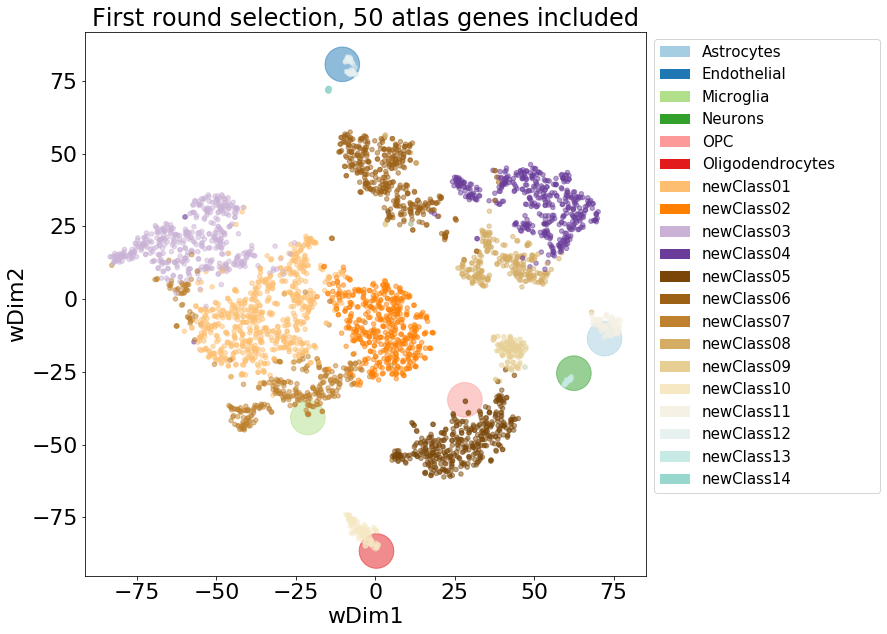

In [29]:
newlut = dict(zip(class_numbersSE,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(class_numbers)-6)))
newcolor = tsnedfSE['class'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
tsnedfSE.plot.scatter('wDim1','wDim2',s=weights*20
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,valsSE,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotateSE_nofetal_selfEdges_weightsEq_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotateSE_nofetal_selfEdges_weightsEq_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.pdf')

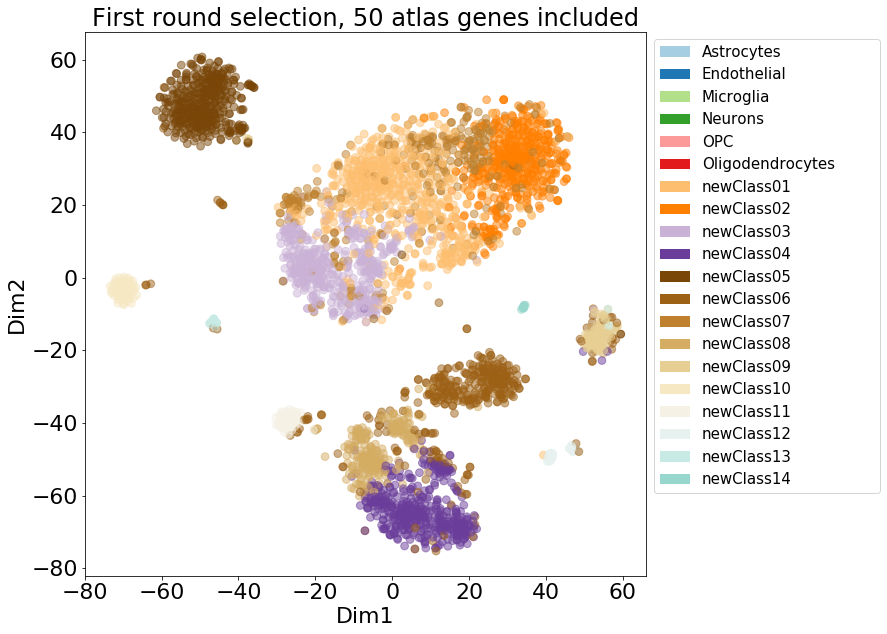

In [30]:
idx = tsnedf[6:].index
GBM_meta.loc[idx,'new_membershipSE'] = tsnedfSE.iloc[6:]['new_membership']
# new results mapped onto old tSNE
newlut = dict(zip(valsSE,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(valsSE)-6)))
newcolor = GBM_meta['new_membershipSE'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
GBM_meta.plot.scatter('Dim1','Dim2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_selfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_selfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.pdf')

# check stability - this re-initializes semiAnnotate(!)

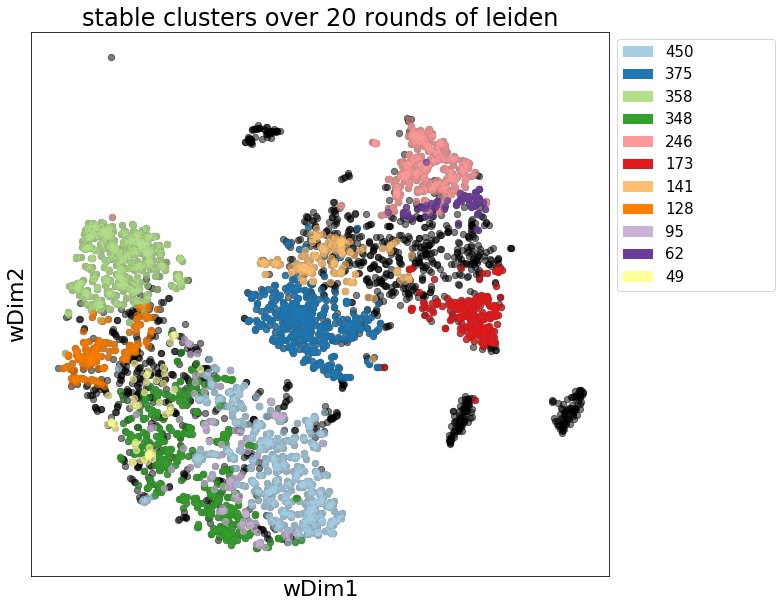

In [11]:
# uses same dict as above

dim = len(matrix_feature_selected.T)
trials = 20
b = c = np.ndarray([trials,dim,dim],np.int32)


for i in range(trials):
    #values = ['Cell_type',30,500,.8,20,respar[i],True]
    
    #ts, class_numSE,valSE,wdmSE= li.semiAnnotate_to_pca_to_tsnedf(matrix_feature_selected,weights,BA_newmeta,GBM_meta,**kwds)
    ts, class_numSE,valSE = li.semiAnnotate_using_tsnedf(matrix_feature_selected,weights,BA_newmeta,GBM_meta,tsnedfSE,**kwds)
    newdf2 = ts.copy()
    newdf2['class2'] = newdf2['class']+1
    df = pd.pivot_table(newdf2,values='class2',index=newdf2.index,columns='new_membership',aggfunc=np.count_nonzero).fillna(0).copy()                     
    a = df.T.corr().values
    b[i][:][:] = a
    #c[i][:][:] = np.corrcoef(a)

    
average_df = pd.DataFrame(np.average(b,axis=0),index=df.index,columns=df.index)
#average_corr = pd.DataFrame(np.average(c,axis=0),index=df.index,columns=df.index)
drop_idx = average_df[(average_df[average_df==1].sum()==1)].index
stable_pairs = average_df.drop(drop_idx).drop(drop_idx,axis=1)
stablep = stable_pairs[stable_pairs==1].fillna(0)

# select groups with same size as value counts (this avoids me having to perform hierarchical clustering)
idx = stablep.sum().value_counts().index.astype(int)
val = stablep.sum().value_counts().values
df = pd.DataFrame(index=range(len(idx)), columns=['idx','val'])
df['idx'] = idx;df['val'] = val
groups = df[df.eq(df.iloc[:, 0], axis=0).all(1)==True].idx.values

idxs = []
for cluster in groups:
    idxs.append(list(stablep[stablep.sum()==cluster].index))
clusterdict = dict(zip(groups,idxs))


len(groups)
groupi = groups[:11] # take the 11 largest groups



values = sns.color_palette('Paired',len(groupi))
lut = dict(zip(groupi,values))

f,ax = plt.subplots(figsize=(11,10))

tsnedfSE.plot.scatter('wDim1','wDim2',ax=ax,color='k',s=2*20,alpha=.5)
for group in groupi:
    idxes = clusterdict[group]
    tsnedfSE.loc[idxes].plot.scatter('wDim1','wDim2',ax=ax,color=lut[group],s=40,alpha=.6)

for x,y in lut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
    plt.legend(handles[:],labels[:],bbox_to_anchor=(1, .9, .3, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.yticks([]);plt.xticks([])
plt.title('stable clusters over '+str(trials)+' rounds of leiden')
plt.gcf().subplots_adjust(left=.05,right=0.78)
plt.show()
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotateStability'+date+'.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotateStability'+date+'.pdf')

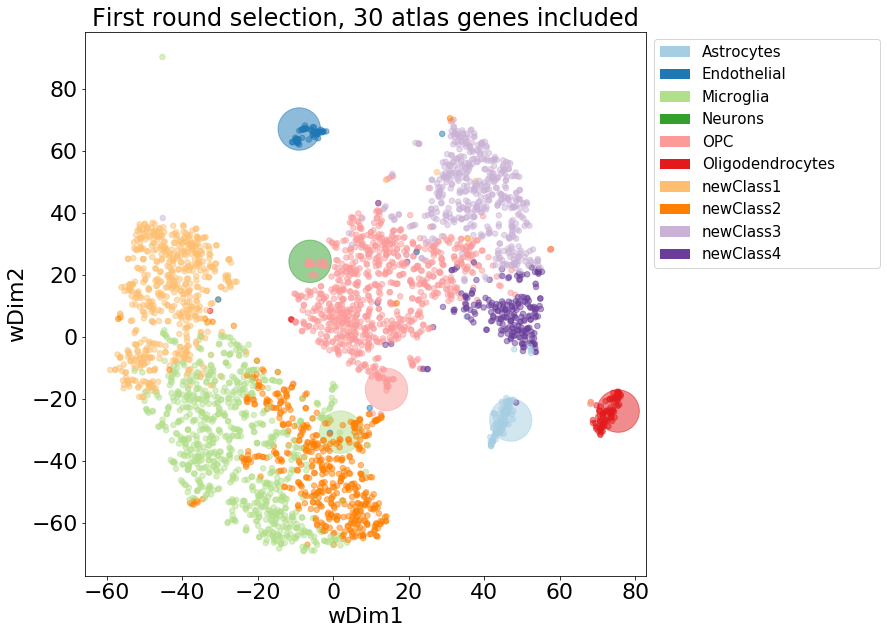

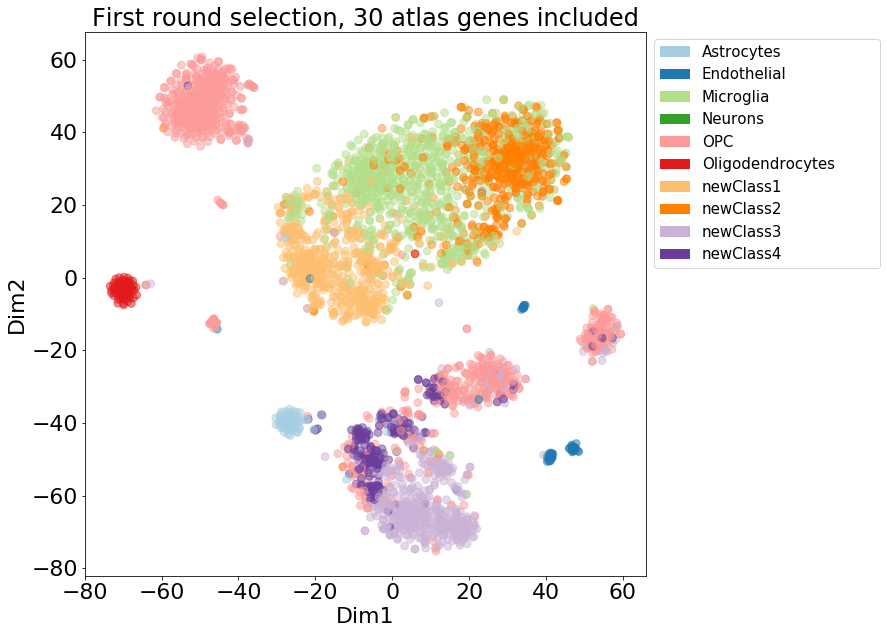

In [12]:
#post stability classes
newlut = dict(zip(valSE,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(valSE)-6)))
newcolor = ts['new_membership'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
ts.plot.scatter('wDim1','wDim2',s=weights*30
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,valSE,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotateSE_nofetal_selfEdges_weightsEq_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'_postStab.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotateSE_nofetal_selfEdges_weightsEq_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'_postStab.pdf')

idx = tsnedf[6:].index
GBM_meta.loc[idx,'new_membershipSE_postStab'] = ts.iloc[6:]['new_membership']
# new results mapped onto old tSNE
newlut = dict(zip(valSE,sns.color_palette('Paired', 10)+sns.color_palette('BrBG',len(valSE)-6)))
newcolor = GBM_meta['new_membershipSE_postStab'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
GBM_meta.plot.scatter('Dim1','Dim2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_selfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'_postStab.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/semiAnnotate_nofetal_selfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'_postStab.pdf')

In [87]:
matrix_feature_selected.to_csv(savedir+date+'/feature_selected_matrix_'+date+'.csv')
GBM_meta.to_csv(savedir+date+'/new_cells_metadata_'+date+'.csv')
tsnedf.to_csv(savedir+date+'/tsnedf_noselfEdging_'+date+'.csv')
tsnedfSE.to_csv(savedir+date+'/tsnedf_selfEdging_'+date+'.csv')
ts.to_csv(savedir+date+'/tsnedf_selfEdging_postStab_'+date+'.csv')

In [13]:
def make_pairdf(correlation_matrix,NN,tsne_df):
    pairs = li.make_pairs(correlation_matrix,2,NN)
    pair_df = pd.DataFrame(pairs)
    for pair in pair_df.index:
        cell1 = pair_df.loc[pair,0]
        cell2 = pair_df.loc[pair,1]
        class1 = tsne_df.loc[cell1,'new_membership']
        class2 = tsne_df.loc[cell2,'new_membership']
        if class1==class2:
            pair_df.loc[pair,'edge_type'] = 'inter_class'
        else:
            pair_df.loc[pair,'edge_type'] = 'intra_class'
        pair_df.loc[pair,'correlation'] = 1 - correlation_matrix.loc[cell1,cell2]
        pair_df.loc[pair,'distance'] = correlation_matrix.loc[cell1,cell2]
        xy1 = tsne_df.loc[cell1][['wDim1','wDim2']]
        xy2 = tsne_df.loc[cell2][['wDim1','wDim2']]
        pair_df.loc[pair,'edge_length'] =  np.sqrt((xy2[0]-xy1[0])**2+(xy2[1]-xy1[1])**2)
    return pair_df

In [14]:
cluster_pair_df = make_pairdf(1-average_df,2,ts)

---------------------------------------
Making list of edges with -100% correlation and up
Max 2 edges per cell.
Found 3595 edges.
---------------------------------------


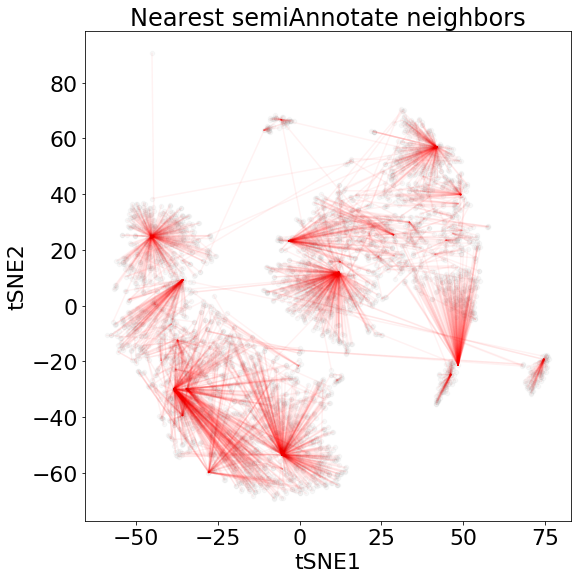

In [16]:
cluster_pair_df#.correlation.sort_values()
#pairs_wSE_95 = li.make_pairs(pd.DataFrame(wdmSE),.05,5)
#olors = sns.color_palette('RdBu_r',5)
f,ax = plt.subplots(figsize=(10,10))
ts.plot.scatter('wDim1','wDim2',figsize=(10,10),ax=ax,alpha=.05,color='gray')
for pair in cluster_pair_df.index:
    xy1 = ts.loc[cluster_pair_df.loc[pair,0]][['wDim1','wDim2']]
    xy2 = ts.loc[cluster_pair_df.loc[pair,1]][['wDim1','wDim2']]
    #corr = pairdf.loc[pair,'correlation']
    ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.05
            ,c='r')

#plt.yticks([]);plt.xticks([])
plt.xlabel('tSNE1'),plt.ylabel('tSNE2')
plt.title('Nearest semiAnnotate neighbors')

plt.gcf().subplots_adjust(right=0.8,bottom=.2)
plt.show()
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/brain_edges_clusterCorr_tsne'+date+'.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/brain_edges_clusterCorr_tsne'+date+'.pdf')

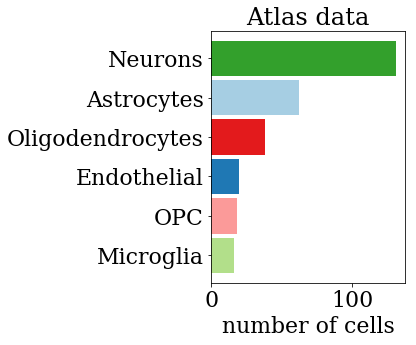

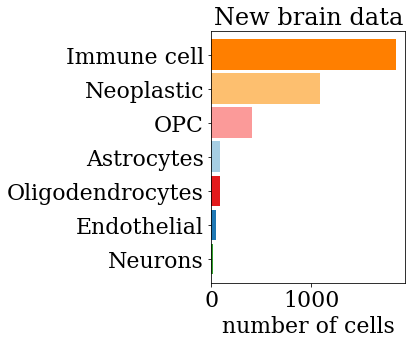

In [308]:
f,ax = plt.subplots(figsize=(6,5))
newlut = dict(zip(np.sort(BA_newmeta['Cell_type'].unique()),sns.color_palette('Paired',len(BA_newmeta['Cell_type'].unique()))))
colors = BA_newmeta['Cell_type'].value_counts().index.map(newlut)
BA_newmeta['Cell_type'].value_counts().plot.barh(width=.9,ax=ax,color=colors)
plt.gca().invert_yaxis()
plt.title('Atlas data')
plt.xlabel('number of cells')
plt.gcf().subplots_adjust(left=.5,right=0.95,bottom=.2,top=.9)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/BrainAtlas_data_original_cellNumBarh.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/BrainAtlas_data_original_cellNumBarh.pdf')

f,ax = plt.subplots(figsize=(6,5))
colors = GBM_meta['Cell_type'].value_counts().index.map(lut)
GBM_meta['Cell_type'].value_counts().plot.barh(width=.9,color=colors,ax=ax)
plt.gca().invert_yaxis()
plt.xlabel('number of cells')
plt.title('New brain data')
plt.gcf().subplots_adjust(left=.5,right=0.95,bottom=.2,top=.9)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/GBM_data_original_cellNumBarh.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/GBM_data_original_cellNumBarh.pdf')

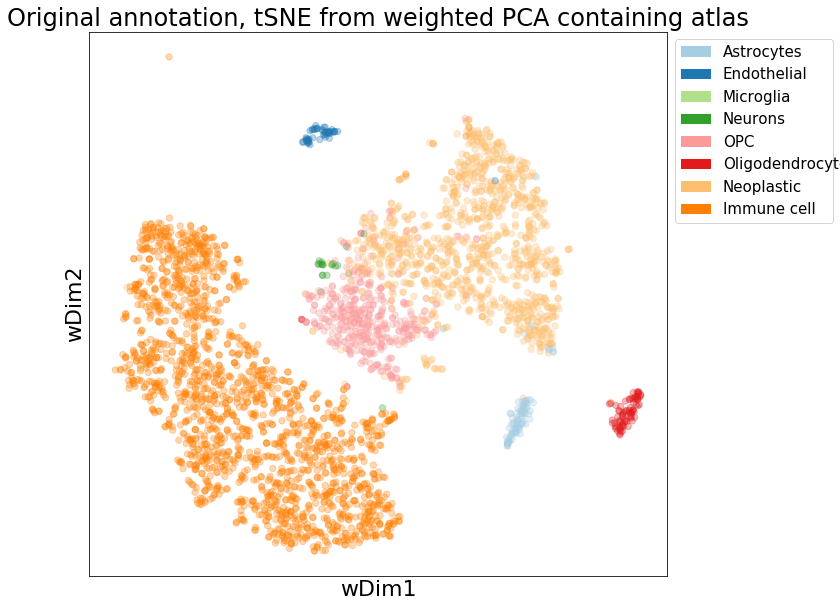

In [17]:
tsnedfSE
newlut
keys = list(tsnedfSE[:6].index)+list(set(tsnedfSE.iloc[6:]['original_membership']).difference(set(tsnedfSE[:6].index)))
values = sns.color_palette('Paired',len(keys))
lut = dict(zip(keys,values))
colors = tsnedfSE[6:].original_membership.map(lut)

f = plt.figure(figsize=(11,10))
gs = gridspec.GridSpec(1,1)
ax = f.add_subplot(gs[0,0])
tsnedfSE[6:].plot.scatter('wDim1','wDim2',ax=ax,color=colors,s=40,alpha=.3)#,label=colors.keys)
for x,y in lut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
    plt.legend(handles[:],labels[:],bbox_to_anchor=(1, .9, .3, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.yticks([]);plt.xticks([])
plt.title('Original annotation, tSNE from weighted PCA containing atlas')
plt.gcf().subplots_adjust(left=.05,right=0.78)
plt.show()
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/tSNE_weightedPCA_originalAnnotation.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/tSNE_weightedPCA_originalAnnotation.pdf')

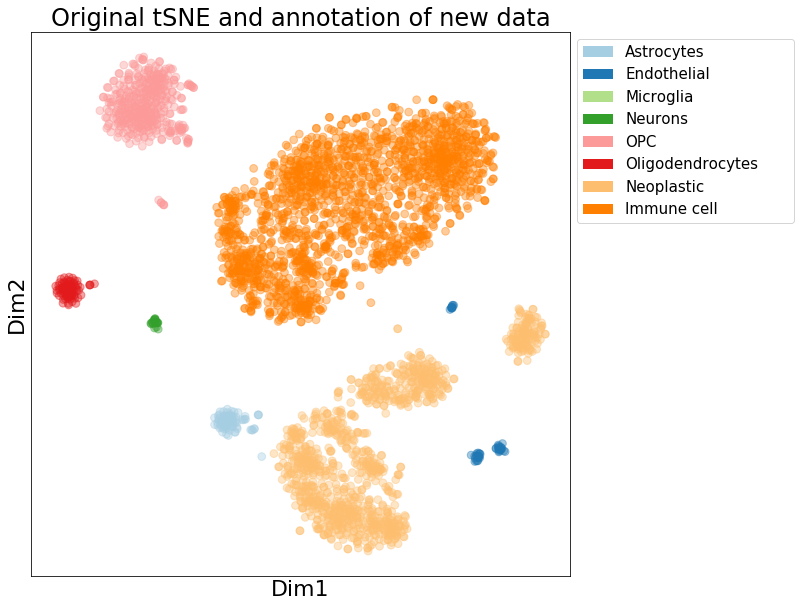

In [18]:
f,ax = plt.subplots(figsize=(11,10))
GBM_meta.plot.scatter('Dim1','Dim2',c=colors,ax=ax,alpha=.4,s=60)

for x,y in lut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.yticks([]);plt.xticks([])
plt.title('Original tSNE and annotation of new data')
plt.gcf().subplots_adjust(left=.05,right=0.73)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/tSNE_original_oldAnnotation_.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/tSNE_original_oldAnnotation_.pdf')

In [19]:
# plot edge length vs correlation as scatter
# colored by inter or intra class edge 
wdmSEdf = pd.DataFrame(wdmSE)
pairs = li.make_pairs(wdmSEdf,2,5)
pairdf = pd.DataFrame(pairs)
for pair in pairdf.index:
    cell1 = pairdf.loc[pair,0]
    cell2 = pairdf.loc[pair,1]
    class1 = tsnedfSE.iloc[cell1]['new_membership']
    class2 = tsnedfSE.iloc[cell2]['new_membership']
    if class1==class2:
        pairdf.loc[pair,'edge_type'] = 'inter_class'
    else:
        pairdf.loc[pair,'edge_type'] = 'intra_class'
    pairdf.loc[pair,'correlation'] = 1 - wdmSEdf.loc[cell1,cell2]
    pairdf.loc[pair,'distance'] = wdmSEdf.loc[cell1,cell2]
    xy1 = tsnedf.iloc[cell1][['wDim1','wDim2']]
    xy2 = tsnedf.iloc[cell2][['wDim1','wDim2']]
    pairdf.loc[pair,'edge_length'] =  np.sqrt((xy2[0]-xy1[0])**2+(xy2[1]-xy1[1])**2)

---------------------------------------
Making list of edges with -100% correlation and up
Max 5 edges per cell.
Found 14380 edges.
---------------------------------------


In [20]:
pairdf.head()

,0,1,edge_type,correlation,distance,edge_length
0,0,3138,inter_class,0.996019,0.003981,9.885516
1,0,3135,inter_class,0.995888,0.004112,9.267828
2,0,685,inter_class,0.994633,0.005367,9.198187
3,0,1929,inter_class,0.994035,0.005965,9.845016
4,1,1436,inter_class,0.964902,0.035098,3.598581


In [21]:
pairdf.edge_type.value_counts()

inter_class    13572
intra_class      808
Name: edge_type, dtype: int64

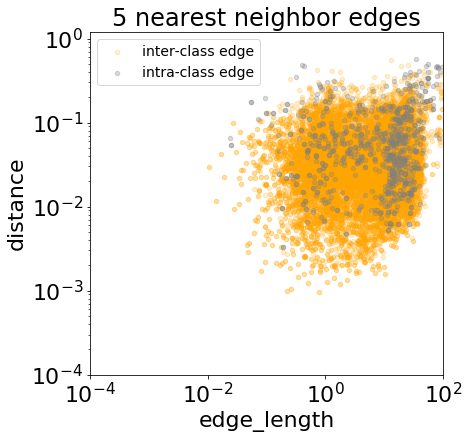

In [22]:
lut = {'inter_class':'orange','intra_class':'gray'}
cols = pairdf['edge_type'].map(lut)
f,ax = plt.subplots()
pairdf[pairdf['edge_type'].str.contains('inter')].plot.scatter('edge_length','distance',alpha=.2,figsize=(7,7),color='orange',label='inter-class edge',ax=ax)
pairdf[pairdf['edge_type'].str.contains('intra')].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color='gray',label='intra-class edge',ax=ax)
plt.yscale('log');plt.xscale('log')
plt.ylim(.0001,1.2)
plt.xlim(.0001,100)
plt.title('5 nearest neighbor edges')
plt.gcf().subplots_adjust(left=0.2,bottom=.2)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/dist_edgelength.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/dist_edgelength.pdf')

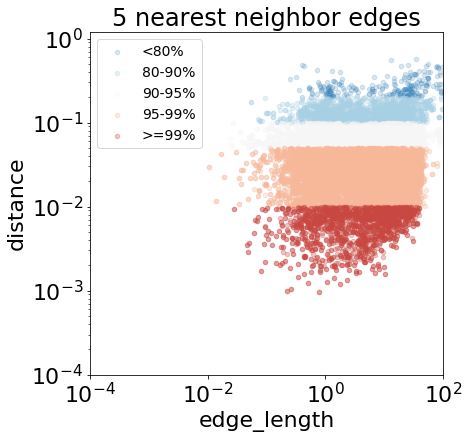

In [23]:
#lut = {'inter_class':'orange','intra_class':'gray'}
#cols = pairdf['edge_type'].map(lut)
colors = sns.color_palette('RdBu_r',5)
f,ax = plt.subplots()
pairdf[pairdf['correlation']<.8].plot.scatter('edge_length','distance',alpha=.2,figsize=(7,7),color=colors[0],label='<80%',ax=ax)
pairdf[(pairdf['correlation']<.9)&(pairdf['correlation']>=.8)].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[1],label='80-90%',ax=ax)
pairdf[(pairdf['correlation']<.95)&(pairdf['correlation']>=.9)].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[2],label='90-95%',ax=ax)
pairdf[(pairdf['correlation']<.99)&(pairdf['correlation']>=.95)].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[3],label='95-99%',ax=ax)
pairdf[pairdf['correlation']>=.99].plot.scatter('edge_length','distance',alpha=.3,figsize=(7,7),color=colors[4],label='>=99%',ax=ax)
plt.yscale('log');plt.xscale('log')
plt.ylim(.0001,1.2)
plt.xlim(.0001,100)
plt.title('5 nearest neighbor edges')
plt.gcf().subplots_adjust(left=0.2,bottom=.2)
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/dist_edgelength_corrcol.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/dist_edgelength_corrcol.pdf')

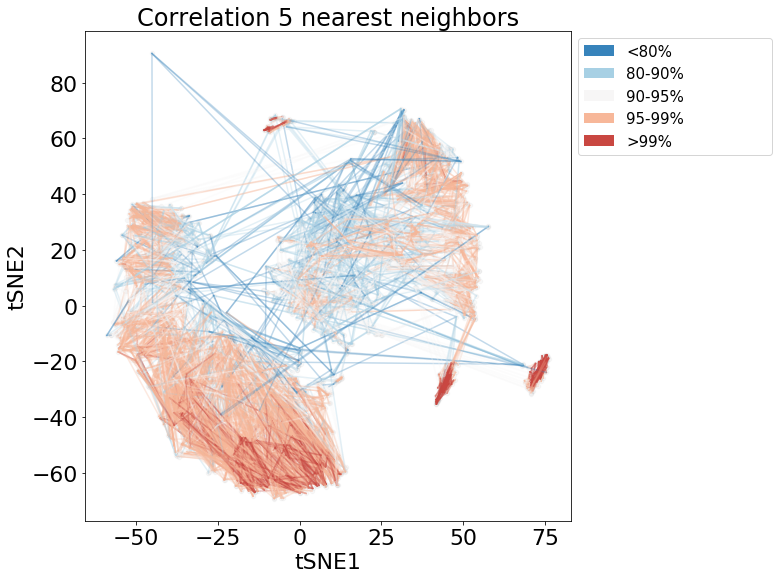

In [24]:
#pairs_wSE_95 = li.make_pairs(pd.DataFrame(wdmSE),.05,5)
colors = sns.color_palette('RdBu_r',5)
f,ax = plt.subplots(figsize=(10,10))
tsnedf.plot.scatter('wDim1','wDim2',figsize=(10,10),ax=ax,alpha=.05,color='gray')
for pair in pairdf.index:
    xy1 = tsnedfSE.iloc[pairdf.loc[pair,0]][['wDim1','wDim2']]
    xy2 = tsnedfSE.iloc[pairdf.loc[pair,1]][['wDim1','wDim2']]
    corr = pairdf.loc[pair,'correlation']
    if corr<.8:
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[0])
    elif (corr>=.8) & (corr<.9):
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[1])
    elif (corr>=.9) & (corr<.95):
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[2])
    elif (corr>=.95) & (corr<.99):
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[3])
    elif corr>=.99:
        ax.plot([xy1[0],xy2[0]],[xy1[1],xy2[1]],alpha=.3
            ,c=colors[4])
#
#plt.yticks([]);plt.xticks([])
handles = ['<80%','80-90%','90-95%','95-99%','>99%']
labs = [f for f in colors]
dictcorr = dict(zip(handles,labs))
for x,y in dictcorr.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handle, labels = ax.get_legend_handles_labels()
    

plt.xlabel('tSNE1'),plt.ylabel('tSNE2')
plt.title('Correlation 5 nearest neighbors')
plt.legend(handle,handles, bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.gcf().subplots_adjust(right=0.8,bottom=.2)
plt.show()
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/brain_edges_corr_tsne'+date+'.png')
f.savefig('../leidenalg/Datasets/Darmanis_Brain/'+date+'/brain_edges_corr_tsne'+date+'.pdf')

In [94]:
# investigate classification using sankey diagram. first massage data into right format
#tsnedfSE


In [25]:
def rgb_to_hex(list_vals):
    hexval=[]
    for r in list_vals:
        r *=255
        hexval.append('#%02X%02X%02X' % (int(round(r[0]*255)),int(round(r[1]*255)),int(round(r[2]*255))))
    return hexval

from collections import defaultdict

def sankey_BB(dataframe,**kwds):
    """
    necessary keywords:
    left_column, right_column,figure_name,savedir,close_plot
    """
    left_col = kwds['left_column']
    right_col = kwds['right_column']
    figname = kwds['figure_name']
    closePlot = kwds['close_plot']
    savedir = kwds['savedir']
    
    left = dataframe[left_col]
    right = dataframe[right_col]

    leftWeight = None
    rightWeight = None
    leftLabels = None
    rightLabels = None
    rightColor = False
    aspect = 20
    fontsize=20
    #figname = 'spyros_brain_noFetal_sankey_bot'
    figureName = figname

    keys = [str(f) for f in set(list(dataframe[left_col].unique())+list(dataframe[right_col].unique()))]
    keys = list(set(list(dataframe[left_col].unique())+list(dataframe[right_col].unique())))
    values=sns.color_palette('husl',len(keys))
    values_hex = rgb_to_hex(values)
    
    colors = dict(zip(keys,values_hex))
    colors[-1]='gray'
    colorDict = colors

    if leftWeight is None:
        leftWeight = []
    if rightWeight is None:
        rightWeight = []
    if leftLabels is None:
        leftLabels = []
    if rightLabels is None:
        rightLabels = []
    # Check weights
    if len(leftWeight) == 0:
        leftWeight = np.ones(len(left))

    if len(rightWeight) == 0:
        rightWeight = leftWeight

    plt.figure()
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')

    # Create Dataframe
    if isinstance(left, pd.Series):
        left = left.reset_index(drop=True)
    if isinstance(right, pd.Series):
        right = right.reset_index(drop=True)
    dataFrame = pd.DataFrame({'left': left, 'right': right, 'leftWeight': leftWeight,
                              'rightWeight': rightWeight}, index=range(len(left)))

    if len(dataFrame[(dataFrame.left.isnull()) | (dataFrame.right.isnull())]):
        raise NullsInFrame('Sankey graph does not support null values.')

    # Identify all labels that appear 'left' or 'right'
    allLabels = pd.Series(np.r_[dataFrame.left.unique(), dataFrame.right.unique()]).unique()

    # Identify left labels
    if len(leftLabels) == 0:
        leftLabels = pd.Series(dataFrame.left.unique()).unique()
    else:
        check_data_matches_labels(leftLabels, dataFrame['left'], 'left')

    # Identify right labels
    if len(rightLabels) == 0:
        rightLabels = pd.Series(dataFrame.right.unique()).unique()
    else:
        check_data_matches_labels(leftLabels, dataFrame['right'], 'right')
    # If no colorDict given, make one
    if colorDict is None:
        colorDict = {}
        palette = "hls"
        colorPalette = sns.color_palette(palette, len(allLabels))
        for i, label in enumerate(allLabels):
            colorDict[label] = colorPalette[i]
    else:
        missing = [label for label in allLabels if label not in colorDict.keys()]
        if missing:
            msg = "The colorDict parameter is missing values for the following labels : "
            msg += '{}'.format(', '.join(missing))
            raise ValueError(msg)

    # Determine widths of individual strips
    ns_l = defaultdict()
    ns_r = defaultdict()
    for leftLabel in leftLabels:
        leftDict = {}
        rightDict = {}
        for rightLabel in rightLabels:
            leftDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].leftWeight.sum()
            rightDict[rightLabel] = dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)].rightWeight.sum()
        ns_l[leftLabel] = leftDict
        ns_r[leftLabel] = rightDict

    # Determine positions of left label patches and total widths
    leftWidths = defaultdict()
    leftLabels[::-1].sort()
    rightLabels[::-1].sort()
    rightLabels = rightLabels[[-1]+list(range(len(rightLabels)-1))]
    for i, leftLabel in enumerate(leftLabels):
        #print(leftLabel)
        myD = {}
        myD['left'] = dataFrame[dataFrame.left == leftLabel].leftWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['left']
        else:
            myD['bottom'] = leftWidths[leftLabels[i - 1]]['top'] + 0.02 * dataFrame.leftWeight.sum()
            myD['top'] = myD['bottom'] + myD['left']
            topEdge = myD['top']
        leftWidths[leftLabel] = myD

    # Determine positions of right label patches and total widths
    rightWidths = defaultdict()
    for i, rightLabel in enumerate(rightLabels):
        myD = {}
        myD['right'] = dataFrame[dataFrame.right == rightLabel].rightWeight.sum()
        if i == 0:
            myD['bottom'] = 0
            myD['top'] = myD['right']
        else:
            myD['bottom'] = rightWidths[rightLabels[i - 1]]['top'] + 0.02 * dataFrame.rightWeight.sum()
            myD['top'] = myD['bottom'] + myD['right']
            topEdge = myD['top']
        rightWidths[rightLabel] = myD

    # Total vertical extent of diagram
    xMax = topEdge / aspect

    # Draw vertical bars on left and right of each  label's section & print label
    for leftLabel in leftLabels:
        plt.fill_between(
            [-0.02 * xMax, 0],
            2 * [leftWidths[leftLabel]['bottom']],
            2 * [leftWidths[leftLabel]['bottom'] + leftWidths[leftLabel]['left']],
            color=colorDict[leftLabel],
            alpha=0.99
        )
        plt.text(
            -0.05 * xMax,
            leftWidths[leftLabel]['bottom'] + 0.5 * leftWidths[leftLabel]['left'],
            leftLabel,
            {'ha': 'right', 'va': 'center'},
            fontsize=fontsize
        )
    for rightLabel in rightLabels:
        plt.fill_between(
            [xMax, 1.02 * xMax], 2 * [rightWidths[rightLabel]['bottom']],
            2 * [rightWidths[rightLabel]['bottom'] + rightWidths[rightLabel]['right']],
            color=colorDict[rightLabel],
            alpha=0.99
        )
        plt.text(
            1.05 * xMax,
            rightWidths[rightLabel]['bottom'] + 0.5 * rightWidths[rightLabel]['right'],
            rightLabel,
            {'ha': 'left', 'va': 'center'},
            fontsize=fontsize
        )

    # Plot strips
    for leftLabel in leftLabels:
        for rightLabel in rightLabels:
            labelColor = leftLabel
            if rightColor:
                labelColor = rightLabel
            if len(dataFrame[(dataFrame.left == leftLabel) & (dataFrame.right == rightLabel)]) > 0:
                # Create array of y values for each strip, half at left value,
                # half at right, convolve
                ys_d = np.array(50 * [leftWidths[leftLabel]['bottom']] + 50 * [rightWidths[rightLabel]['bottom']])
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_d = np.convolve(ys_d, 0.05 * np.ones(20), mode='valid')
                ys_u = np.array(50 * [leftWidths[leftLabel]['bottom'] + ns_l[leftLabel][rightLabel]] + 50 * [rightWidths[rightLabel]['bottom'] + ns_r[leftLabel][rightLabel]])
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')
                ys_u = np.convolve(ys_u, 0.05 * np.ones(20), mode='valid')

                # Update bottom edges at each label so next strip starts at the right place
                leftWidths[leftLabel]['bottom'] += ns_l[leftLabel][rightLabel]
                rightWidths[rightLabel]['bottom'] += ns_r[leftLabel][rightLabel]
                plt.fill_between(
                    np.linspace(0, xMax, len(ys_d)), ys_d, ys_u, alpha=0.65,
                    color=colorDict[labelColor]
                )
    plt.gca().axis('off')
    plt.gcf().set_size_inches(6, 18)
    if figureName != None:
        plt.savefig(savedir+"{}.png".format(figureName), bbox_inches='tight', dpi=150)
        plt.savefig(savedir+"{}.pdf".format(figureName), bbox_inches='tight', dpi=150)
    if closePlot:
        plt.close()

In [26]:
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_noFetal_selfEgdes_'+date
        ,'../leidenalg/Datasets/Darmanis_Brain/'+date+'/',True]
kw = dict(zip(keys,valu))
sankey_BB(ts[6:],**kw)

In [117]:
matrix_feature_selected
tsnedf.groupby('new_membership').count()

#tsnedf

,wDim1,wDim2,class,original_membership,uDim1,uDim2
new_membership,,,,,,
Astrocytes,100,100,100,99,100,100
Endothelial,60,60,60,59,60,60
Microglia,2,2,2,1,2,2
Neurons,22,22,22,21,22,22
OPC,1,1,1,0,1,1
Oligodendrocytes,1,1,1,0,1,1
hybrid,3,3,3,2,3,3
hybrids,2,2,2,1,2,2
newClass1,1278,1278,1278,1278,1278,1278


In [82]:
from scipy.spatial.distance import pdist, squareform
from fastcluster import linkage
from polo import optimal_leaf_ordering

def _optimal_order(data, **kwargs):
    """ Optimal leaf ordering
        **kwargs passed to pdist e.g. metric='correlation'
    """
    d = pdist(data, **kwargs)
    link = linkage(d, method='average')
    optimal_order = optimal_leaf_ordering(link, d)
    return optimal_order

def make_top_genes(feat_sel_matrix,tsne_df,column_name,numgenes):
    cols = tsne_df[column_name].unique()
    genes = pd.DataFrame(index=range(numgenes),columns=cols)
    class_exp = pd.DataFrame(index=feat_sel_matrix.index,columns=cols)
    genes_OD = genes.copy()
    gexp = genes.copy()
    for group in cols:
        members = tsne_df[tsne_df[column_name]==group].index
        class_exp[group] = feat_sel_matrix.loc[:, members].T.mean()
        # this takes the top expressing genes per class in the feature selected matrix
        genes[group] = feat_sel_matrix[members].mean(axis=1).sort_values(ascending=False)[:numgenes].index
        # this retrieves the overdispersed genes in a class, when compared to the average 
        """features = set()
        ge1 = feat_sel_matrix.loc[:, members]
        ge2 = (feat_sel_matrix.loc[:, :].sum(axis=1) - ge1).divide(len(feat_sel_matrix.T) - len(members))
        fold_change = np.log2(ge1 + 0.1) - np.log2(ge2 + 0.1)
        markers = np.argpartition(fold_change, -numgenes)[-numgenes:]
        genes_OD[group] = markers
        features |= set(markers)"""

    features = set()
    for group in cols:
        ge1 = class_exp[group]
        ge2 = (class_exp.sum(axis=1) - ge1).divide(len(class_exp.T) - 1)
        fold_change = np.log2(ge1 + 0.1) - np.log2(ge2 + 0.1)
        markers = np.argpartition(fold_change.values, -numgenes)[-numgenes:]
        #markers = fold_change.sort_values()[-numgenes:]
        #import ipdb; ipdb.set_trace()
        #print(markers.index)
        genelist = class_exp.iloc[markers].index
        genes_OD[group] = genelist
        features |= set(genelist)
        #features1 |= set(markers1.index)
        
        
    unique_genes = set()
    for c in genes.columns:
        unique_genes |= set(genes[c])
    panel = pd.DataFrame(index=unique_genes,columns=cols)
    panel_OD = pd.DataFrame(index=features,columns=cols)
    for group in cols:
        members = tsne_df[tsne_df[column_name]==group].index
        panel[group] = feat_sel_matrix.loc[panel.index,members].mean(axis=1)
        panel_OD[group] = feat_sel_matrix.loc[panel_OD.index,members].mean(axis=1)
    return panel,panel_OD

def ordered_classes(panel):
    row_link = _optimal_order(panel.T.corr(), metric='correlation')
    col_link = _optimal_order(panel.corr(), metric='correlation')
    #cg = sns.clustermap(panel.T.corr(), row_linkage=row_link, col_linkage=row_link,figsize=(20,55),xticklabels=False)
    cg = sns.clustermap(np.log2(panel+0.001),row_linkage=row_link,col_linkage=col_link)
    plt.close()
    rows = cg.dendrogram_row.reordered_ind
    columns = cg.dendrogram_col.reordered_ind
    
    row_names = list(panel.iloc[rows].index)
    col_names = list(panel.T.iloc[columns].index)
    return row_names, col_names

def order_correlation_matrix(matrix):
    row_link = _optimal_order(matrix, metric='correlation')
    cg = sns.clustermap(matrix,row_linkage=row_link,col_linkage=col_link)
    plt.close()
    rows = cg.dendrogram_row.reordered_ind
    row_names = list(matrix.iloc[rows].index)
    return row_names

def plot_dot(panel,rows,columns,**kwds):
    figname = kwds['figure_name']
    savedir = kwds['savedir']
    xgrid = list(range(len(panel.columns)))
    ygrid = list(range(40))
    import get_timestamp as time
    date = time.ymd()
    if len(panel)<50:
        f = plt.figure(figsize=(20,50))
    else:
        f = plt.figure(figsize=(20,len(panel)))
    i=0
    for gene in panel.loc[rows].index:
        temp = panel[panel.index==gene].loc[:,columns]
        #temp = sizes[sizes.index==gene].iloc[:,columnz].multiply(10)
        plt.scatter(xgrid,np.ones(len(xgrid))*i,s=temp.divide(1),alpha=.5)
        i+=1
    plt.yticks(np.arange(len(panel)),rows)
    plt.xticks(np.arange(len(panel.T)),columns,rotation=90)
    f.savefig(savedir+'dotplot_'+figname+'.png')
    f.savefig(savedir+'dotplot_'+figname+'.pdf')
    plt.close(f)
    if len(panel)<50:
        f = plt.figure(figsize=(20,50))
    else:
        f = plt.figure(figsize=(20,len(panel)))
    i=0
    for gene in panel.loc[rows].index:
        temp = panel[panel.index==gene].loc[:,columns]
        #temp = sizes[sizes.index==gene].iloc[:,columnz].multiply(10)
        plt.scatter(xgrid,np.ones(len(xgrid))*i,s=np.log2(temp).multiply(70),alpha=.5)
        i+=1
    plt.yticks(np.arange(len(panel)),rows)
    plt.xticks(np.arange(len(panel.T)),columns,rotation=90)
    f.savefig(savedir+'dotplot_log2_'+figname+'.png')
    f.savefig(savedir+'dotplot_log2_'+figname+'.pdf')
    plt.close(f)
    
def make_dotplot(feat_sel_matrix,tsne_df,numgenes,**kwargs):
    column_name = kwargs['right_column']
    gene_panel,panel_overdisp = make_top_genes(feat_sel_matrix,tsne_df,column_name,numgenes)
    r,c = ordered_classes(gene_panel)
    rOD,cOD = ordered_classes(panel_overdisp)
    kwargs['figure_name'] = kwargs['figure_name']+'_topExpressing_'
    plot_dot(gene_panel,r,c,**kwargs)
    kwargs['figure_name'] = kwargs['figure_name']+'_overdispersed_'
    plot_dot(panel_overdisp,rOD,cOD,**kwargs)
    return gene_panel,r,c
    

In [153]:
"""keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_noFetal_NoSelfEgdes_top5_'
        ,'../leidenalg/Datasets/Darmanis_Brain/',True]
kw = dict(zip(keys,valu))
genePanel5,ro5,co5 = make_dotplot(matrix_feature_selected,tsnedf,5,**kw)"""

In [139]:
"""keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_noFetal_NoSelfEgdes_newcells_'
        ,'../leidenalg/Datasets/Darmanis_Brain/',True]
kw = dict(zip(keys,valu))
genePanelNC,roNC,coNC = make_dotplot(matrix_feature_selected.iloc[:,8:],tsnedf[8:],20,**kw)
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_noFetal_NoSelfEgdes_atlascells_'
        ,'../leidenalg/Datasets/Darmanis_Brain/',True]
kw = dict(zip(keys,valu))
genePanelOC,roOC,coOC = make_dotplot(matrix_feature_selected.iloc[:,:8],tsnedf[:8],20,**kw)"""

In [83]:
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_SelfEgdes_top5'
        ,'../leidenalg/Datasets/Darmanis_Brain/'+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSE,roSE,coSE = make_dotplot(matrix_feature_selected,ts,5,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_SelfEgdes_top10'
        ,'../leidenalg/Datasets/Darmanis_Brain/'+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSE1,roSE,coSE = make_dotplot(matrix_feature_selected,ts,10,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_SelfEgdes_top15'
        ,'../leidenalg/Datasets/Darmanis_Brain/'+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSE,roSE,coSE = make_dotplot(matrix_feature_selected,ts,15,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','spyros_classification_SelfEgdes_top20'
        ,'../leidenalg/Datasets/Darmanis_Brain/'+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSE,roSE,coSE = make_dotplot(matrix_feature_selected,ts,20,**kw)

/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in log2


In [236]:
top,od = make_top_genes(matrix_feature_selected,ts,'new_membership',20)

/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [81]:
print(len(genePanelSE))
print(len(genePanelSE1))

83
44


In [54]:
cols = ts['new_membership'].unique()
genes = pd.DataFrame(index=range(10),columns=cols)
class_exp = pd.DataFrame(index=matrix_feature_selected.index,columns=cols)
genes_OD = genes.copy()

for group in cols:
    members = ts[ts['new_membership']==group].index
    class_exp[group] = matrix_feature_selected.loc[:, members].T.mean()
features = set()
for group in cols:
    ge1 = class_exp[group]
    ge2 = (class_exp.sum(axis=1) - ge1).divide(len(class_exp.T) - 1)
    fold_change = np.log2(ge1 + 0.1) - np.log2(ge2 + 0.1)
    markers = np.argpartition(fold_change.values, -20)[-20:]
    
    markers1 = fold_change.sort_values()[-20:]
    break
    #print(markers.index)
    genes_OD[group] = markers
    features |= set(markers.index)

In [55]:
print(fold_change.iloc[np.argpartition(fold_change.values, -3)[-3:]].sort_values())
print(fold_change.values.max())
print(fold_change.sort_values().iloc[-3:])

GCGR         7.915055
AGXT2L1      8.263435
LOC286370    8.911930
dtype: float64
8.911929633378868
GCGR         7.915055
AGXT2L1      8.263435
LOC286370    8.911930
dtype: float64


In [60]:
markers
class_exp.iloc[markers].index

Index(['SLC2A4', 'LOC285441', 'SPARCL1', 'FBXO2', 'SLC7A10', 'ATP1A2',
       'FLJ42875', 'GPR98', 'AMOT', 'WIF1', 'HIST1H1B', 'C11orf92', 'SLC1A2',
       'LEFTY1', 'TMPRSS3', 'GPAM', 'ACSBG1', 'GCGR', 'AGXT2L1', 'LOC286370'],
      dtype='object')

In [85]:
date

'20190717142414'

In [84]:
cluster_pair_df[1].value_counts()

1001000033.D4     450
1001000249.F6     375
1001000246.H7     358
1001000033.A2     348
1001000184.H8     246
1001000018.F11    173
1001000187.E4     141
1001000229.D8     129
1001000240.H8      95
1001000181.D2      82
1001000231.F10     82
1001000036.G3      82
1001000184.C11     62
1001000230.D4      50
1001000260.A2      38
1001000229.E12     37
1001000032.H5      33
1001000255.F3      28
1001000037.F5      28
1001000185.F7      24
1001000258.G2      21
1001000229.G5      20
1001000229.G11     15
1001000174.H9      13
1001000182.B10     13
1001000179.A2      13
1001000238.H7      13
1001000037.E10     12
1001000231.E7      12
1001000185.A1      11
                 ... 
1001000255.F4       1
1001000241.A12      1
1001000175.D11      1
1001000183.C12      1
1001000250.B8       1
1001000177.C3       1
1001000031.G5       1
1001000174.F6       1
1001000037.B7       1
1001000229.G2       1
1001000247.G8       1
1001000231.B9       1
1001000174.A1       1
1001000179.D1       1
1001000012